# 🐛 Debugging the discrepancy in sea ice thickness between CICE and WW3 

In [61]:
import intake
from intake import cat
# from datatree import DataTree, map_over_subtree

from dask.distributed import Client
import glob
import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf
import re

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft
import seaborn as sns
from cycler import cycler

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
from plot_settings import *
from fstd import *
from attenuation_models import *
test()

colors = sns.color_palette("colorblind")
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)
𝜋 = np.pi
PUNY = 1e-11

Functions from get_files.py imported!


In [62]:
# PATH = "/scratch/tm70/ek4684/access-om3/archive/771-MCW_100km_jra_ryf/output001"
# PATH = "/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf"
# PATH = "/scratch/tm70/ek4684/access-om3/archive/771-MCW_100km_jra_ryf/output002"
PATH = "/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4"
# PATH = "/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf"

# PATH = "/scratch/ps29/nd0349/access-om3/archive/IC4-IC4M2-MCW_100km_jra_iaf-uncoupled/output000"
# PATH = "/scratch/ps29/nd0349/access-om3/archive/771-MCW_100km_jra_ryf/output003"
# PATH = "/scratch/ps29/nd0349/access-om3/archive/771-MCW_100km_jra_ryf/output006"

# PATH = "/scratch/ps29/nd0349/access-om3/archive/IC3-MCW-100km_jra_ryf/output000"
# PATH = "/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4"
# PATH = "/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf"


In [63]:
grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')

from pathlib import Path

# cice_files = sorted(glob.glob(f"{PATH}/access-om3.cice.r*.nc"))

cice_files = sorted(glob.glob(f"{PATH}/access-om3.cice.1*.nc"))#[::30]
# cice_files = sorted(glob.glob(f"{PATH}/access-om3.cice_inst*.nc"))
ds_cice = xr.open_mfdataset(cice_files,
                            combine='by_coords',
                            data_vars='minimal',
                            coords='minimal',
                            compat='override'
                           )
ds_cice.attrs['intake_esm_attrs:realm'] = "ice"

ds_cice.coords['TLON'] = np.degrees(grid_ds['tlon'])
ds_cice.coords['TLAT'] = np.degrees(grid_ds['tlat'])
ds_cice['tarea'] = np.degrees(grid_ds['tarea'])

ww3_files = sorted(glob.glob(f"{PATH}/access-om3.ww3.*.nc"))#[::100]
ds_ww3 = xr.open_mfdataset(ww3_files,
                        combine='by_coords',
                        data_vars='minimal',
                        coords='minimal',
                        compat='override'
                        )
ds_ww3.coords['lon'] = ds_ww3['lon']
ds_ww3.coords['lat'] = ds_ww3['lat']
ds_ww3.attrs['intake_esm_attrs:realm'] = "wave"
ds_ww3


# mom_files = sorted(glob.glob(f"{PATH}/access-om3.mom6.*.nc"))#[::100]
# ds_mom = xr.open_mfdataset(mom_files,
#                         combine='by_coords',
#                         data_vars='minimal',
#                         coords='minimal',
#                         compat='override'
#                         )
# ds_mom.coords['TLON'] = np.degrees(grid_ds['tlon'])
# ds_mom.coords['TLAT'] = np.degrees(grid_ds['tlat'])
# ds_mom


# med_files = sorted(glob.glob(f"{PATH}/access-om3.cpl*.nc"))[0]
# ds_med = xr.open_mfdataset(med_files,
#                         combine='by_coords',
#                         data_vars='minimal',
#                         coords='minimal',
#                         compat='override',
#                         decode_times=False
#                         )
# ds_med.coords['TLON'] = np.degrees(grid_ds['tlon'])
# ds_med.coords['TLAT'] = np.degrees(grid_ds['tlat'])
# ds_med

<xarray.Dataset> Size: 3GB
Dimensions:  (ny: 300, nx: 360, time: 175, freq: 25)
Coordinates:
    lon      (ny, nx) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat      (ny, nx) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
  * time     (time) object 1kB 1900-01-02 00:00:00 ... 1900-06-25 00:00:00
Dimensions without coordinates: ny, nx, freq
Data variables: (12/15)
    mapsta   (time, ny, nx) int32 76MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    UAX      (time, ny, nx) float32 76MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    UAY      (time, ny, nx) float32 76MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICE      (time, ny, nx) float32 76MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEH     (time, ny, nx) float32 76MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEF     (time, ny, nx) float32 76MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ...       ...
    T01      (time, ny, nx) float32 76MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    FP0      (time, ny, nx) float32 76MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    THM      (time, ny, nx) float32 76MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    EF       (time, freq, ny, nx) float32 2GB dask.array<chunksize=(1, 25, 300, 360), meta=np.ndarray>
    USSX     (time, ny, nx) float32 76MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    USSY     (time, ny, nx) float32 76MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes:
    intake_esm_attrs:realm:  wave

In [60]:
ww3_files

['/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4/access-om3.ww3.hi.1900-01-02-00000.nc',
 '/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4/access-om3.ww3.hi.1900-01-03-00000.nc',
 '/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4/access-om3.ww3.hi.1900-01-04-00000.nc',
 '/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4/access-om3.ww3.hi.1900-01-05-00000.nc',
 '/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4/access-om3.ww3.hi.1900-01-06-00000.nc',
 '/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4/access-om3.ww3.hi.1900-01-07-00000.nc',
 '/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4/access-om3.ww3.hi.1900-01-08-00000.nc',
 '/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4/access-om3.ww3.hi.1900-01-09-00000.nc',
 '/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jra_ryf_IC4/access-om3.ww3.hi.1900-01-10-00000.nc',
 '/scratch/tm70/ek4684/access-om3/work/771-MCW_100km_jr

In [5]:
# ds_cice

## Mediator ice thicknesses

In [51]:
ds_med

NameError: name 'ds_med' is not defined

In [ ]:
# Choose time index
time_idx = -1

# Define projection and transform
transform = ccrs.PlateCarree()
proj = ccrs.SouthPolarStereo()
hemisphere = 'south'
dims = [1,5]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

# Compute fields
cice_thick = ds_cice['hi'].where(ds_cice['aice']>PUNY).isel(time=time_idx)
iceImp = ds_med['iceImp_Si_thick'].where(ds_med['iceImp_Si_ifrac']>PUNY).isel(time=time_idx)
ice_vice = ds_med['iceImp_Si_vice'].isel(time=time_idx)
ice_ifrac = ds_med['iceImp_Si_ifrac'].isel(time=time_idx)
ice_thick = ice_vice / ice_ifrac
# wav_thick = ds_med['wavExp_Si_thick'].isel(time=time_idx)

iceImp = iceImp.rename({'iceImp_ny': 'nj', 'iceImp_nx': 'ni'})
ice_vice = ice_vice.rename({'iceImp_ny': 'nj', 'iceImp_nx': 'ni'})
ice_ifrac = ice_ifrac.rename({'iceImp_ny': 'nj', 'iceImp_nx': 'ni'})
# iceImp


diff_plot1 = iceImp.values - cice_thick.values
diff_plot2 = iceImp.values - ice_thick.values
v = np.nanmax(np.abs(diff_plot1))

# Define lon/lat variables (adjust names if needed)
tlon = ds_cice['TLON']
tlat = ds_cice['TLAT']

lon = ds_med['TLON']
lat = ds_med['TLAT']

# Plot each field
p1 = axes[0].pcolormesh(tlon, tlat, cice_thick, transform=transform, cmap=cmo.ice)
axes[0].set_title('CICE mean thickness ($h_i$)')
plt.colorbar(p1, ax=axes[0], orientation='horizontal', pad=0.05)

p1 = axes[1].pcolormesh(lon, lat, iceImp, transform=transform, cmap=cmo.ice)
axes[1].set_title('Mediator (thick)')
plt.colorbar(p1, ax=axes[1], orientation='horizontal', pad=0.05)

p2 = axes[2].pcolormesh(lon, lat, ice_thick, transform=transform, cmap=cmo.ice)
axes[2].set_title('Mediator (vice/ifrac)')
plt.colorbar(p2, ax=axes[2], orientation='horizontal', pad=0.05)

# p2 = axes[3].pcolormesh(lon, lat, wav_thick, transform=transform, cmap=cmo.ice)
# axes[3].set_title('Thickness exported to WW3')
# plt.colorbar(p2, ax=axes[3], orientation='horizontal', pad=0.05)

p3 = axes[3].pcolormesh(lon, lat, diff_plot1, transform=transform, cmap=cmo.balance, vmin=-v, vmax=v)
axes[3].set_title('Difference (Si_thick - $h_i$)')
plt.colorbar(p3, ax=axes[3], orientation='horizontal', pad=0.05)

p3 = axes[4].pcolormesh(lon, lat, diff_plot2, transform=transform, cmap=cmo.balance, vmin=-v, vmax=v)
axes[4].set_title('Difference (Si_thick - vice/ifrac)')
plt.colorbar(p3, ax=axes[4], orientation='horizontal', pad=0.05)

# Add coastlines and gridlines
for ax in axes:
    ax.coastlines(resolution='110m', color='k', linewidth=0.8)
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5)
    ax.set_extent([-180, 180, -90, -50], crs=transform)

# plt.tight_layout()
plt.show()

In [ ]:
cice_thick - iceImp

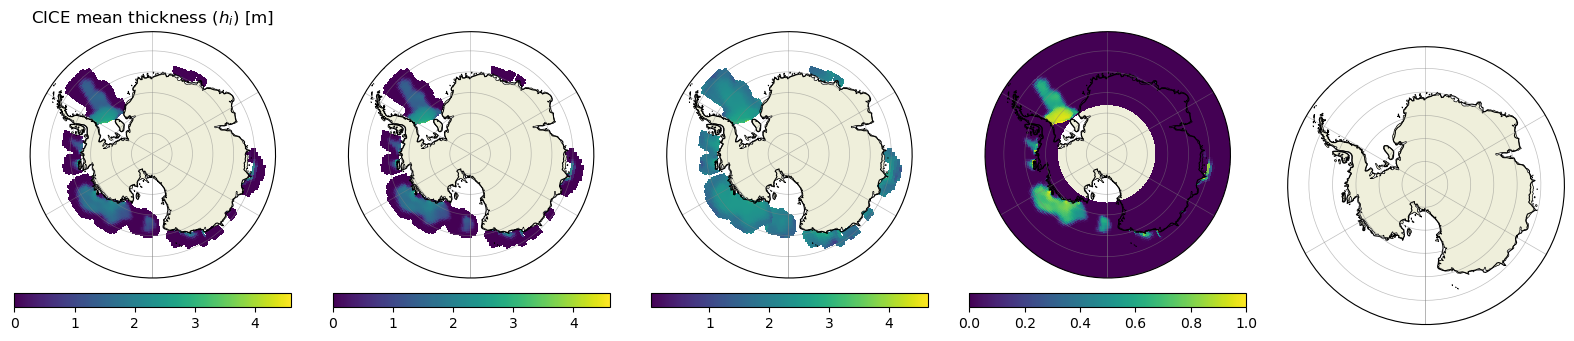

In [86]:
# Choose time index
time_idx = -1

# Define projection and transform
transform = ccrs.PlateCarree()
proj = ccrs.SouthPolarStereo()
hemisphere = 'south'
dims = [1,5]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

# Compute fields
cice_hi = ds_cice['hi'].where(ds_cice['aice']>PUNY).isel(time=time_idx)
cice_vice = ds_cice['vicen'].sum(dim='nc').where(ds_cice['aice']>PUNY).isel(time=time_idx)
cice_aice = ds_cice['aice'].where(ds_cice['aice']>PUNY).isel(time=time_idx)
cice_vice_aice = cice_vice / cice_aice
cice_ai_ncat = (ds_cice['aicen']).where(ds_cice['aice']>PUNY).isel(time=time_idx).sum(dim='nc')

# ds_cice['vicen'].isel(time=time_idx).sum(dim='nc').plot()
# iceImp = ds_med['iceImp_Si_thick'].where(ds_med['iceImp_Si_ifrac']>PUNY).isel(time=time_idx)
# ice_vice = ds_med['iceImp_Si_vice'].isel(time=time_idx)
# ice_ifrac = ds_med['iceImp_Si_ifrac'].isel(time=time_idx)
# ice_thick = ice_vice / ice_ifrac
# wav_thick = ds_med['wavExp_Si_thick'].isel(time=time_idx)

# iceImp = iceImp.rename({'iceImp_ny': 'nj', 'iceImp_nx': 'ni'})
# ice_vice = ice_vice.rename({'iceImp_ny': 'nj', 'iceImp_nx': 'ni'})
# ice_ifrac = ice_ifrac.rename({'iceImp_ny': 'nj', 'iceImp_nx': 'ni'})
# iceImp


# diff_plot1 = iceImp.values - cice_thick.values
# diff_plot2 = iceImp.values - ice_thick.values
# v = np.nanmax(np.abs(diff_plot1))

# Define lon/lat variables (adjust names if needed)
tlon = ds_cice['TLON']
tlat = ds_cice['TLAT']




# Plot each field
p1 = axes[0].pcolormesh(tlon, tlat, cice_hi, transform=transform, cmap='viridis')
axes[0].set_title('CICE mean thickness ($h_i$) [m]')
plt.colorbar(p1, ax=axes[0], orientation='horizontal', pad=0.05)

p1 = axes[1].pcolormesh(tlon, tlat, cice_vice, transform=transform, cmap='viridis')
# axes[1].set_title('Mediator (thick)')
plt.colorbar(p1, ax=axes[1], orientation='horizontal', pad=0.05)

p2 = axes[2].pcolormesh(tlon, tlat, cice_vice_aice, transform=transform, cmap='viridis')
# axes[2].set_title('Mediator (vice/ifrac)')
plt.colorbar(p2, ax=axes[2], orientation='horizontal', pad=0.05)

p2 = axes[3].pcolormesh(tlon, tlat, cice_ai_ncat, transform=transform, cmap='viridis')
# # axes[3].set_title('Thickness exported to WW3')
plt.colorbar(p2, ax=axes[3], orientation='horizontal', pad=0.05)

# p4 = axes[4].pcolormesh(tlon, tlat, ds_cice['vicen'].isel(time=time_idx).isel(nc=1), transform=transform, cmap='viridis')
# axes[3].set_title('Difference (Si_thick - $h_i$)')
# plt.colorbar(p4, ax=axes[4], orientation='horizontal', pad=0.05)

# p3 = axes[4].pcolormesh(lon, lat, diff_plot2, transform=transform, cmap=cmo.balance, vmin=-v, vmax=v)
# axes[4].set_title('Difference (Si_thick - vice/ifrac)')
# plt.colorbar(p3, ax=axes[4], orientation='horizontal', pad=0.05)

# Add coastlines and gridlines
for ax in axes:
    ax.coastlines(resolution='110m', color='k', linewidth=0.8)
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5)
    ax.set_extent([-180, 180, -90, -60], crs=transform)

# plt.tight_layout()
plt.show()

In [87]:
ds_cice['NCAT'].values

array([6.44507217e-01, 1.39143350e+00, 2.47017938e+00, 4.56728792e+00,
       1.00000000e+08])

In [82]:
ds_cice['NCAT']*ds_cice['aicen']

<xarray.DataArray (nc: 5, time: 2, nj: 300, ni: 360)> Size: 9MB
dask.array<mul, shape=(5, 2, 300, 360), dtype=float64, chunksize=(5, 1, 150, 180), chunktype=numpy.ndarray>
Coordinates:
    NCAT     (nc) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
  * time     (time) object 16B 1900-02-05 12:00:00 1900-02-06 12:00:00
    ulat     (nj, ni) float64 864kB ...
    ulon     (nj, ni) float64 864kB ...
    tlat     (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.153 1.145 1.138
    tlon     (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.395 1.396 1.396
    TLON     (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.96 79.97 79.99
    TLAT     (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
Dimensions without coordinates: nc, nj, ni

In [53]:
# ds_cice['vicen'].isel(time=time_idx).sum(dim='nc').plot()

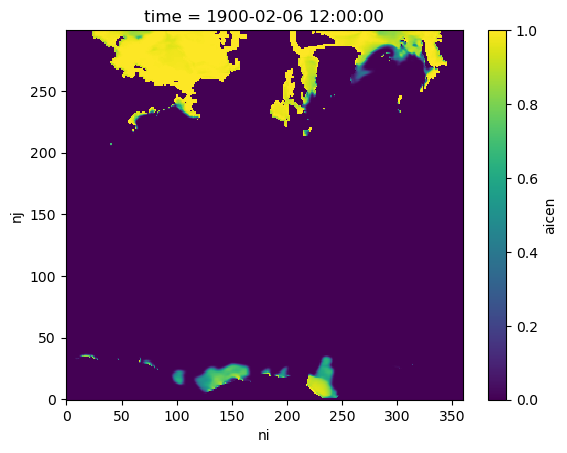

In [59]:
# ds_cice['hi'].isel(time=time_idx).sum(dim='nc').plot()
ds_cice['aicen'].isel(time=time_idx).sum(dim='nc').plot()

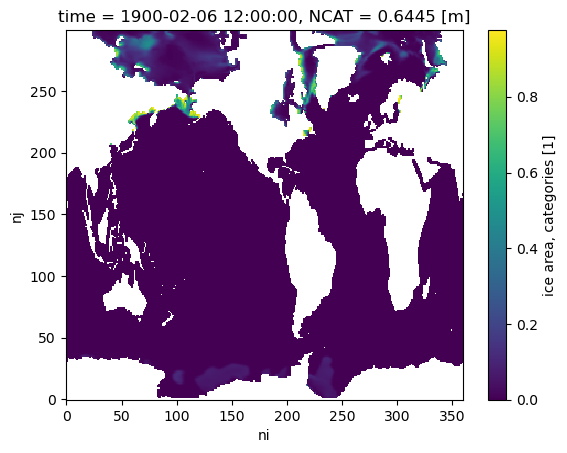

In [60]:
ds_cice['aicen'].isel(time=time_idx).isel(nc=0).plot()

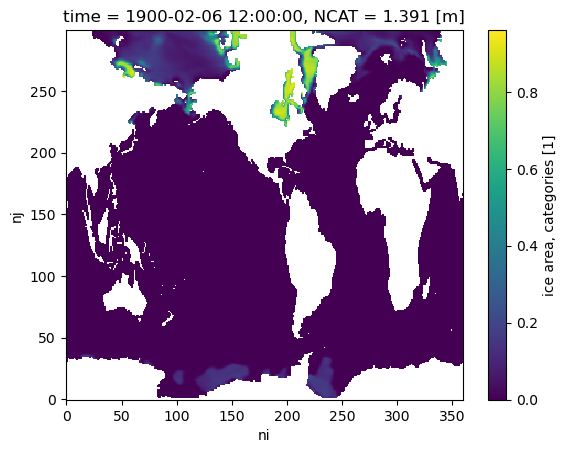

In [61]:
ds_cice['aicen'].isel(time=time_idx).isel(nc=1).plot()

In [20]:
ds_cice['aicen'].isel(time=time_idx).isel(nc=0).plot()

In [63]:
ds_cice['NCAT'].values

array([6.44507217e-01, 1.39143350e+00, 2.47017938e+00, 4.56728792e+00,
       1.00000000e+08])

In [4]:
# tlon.isel(ni=100).mean().values

## Ice and waves

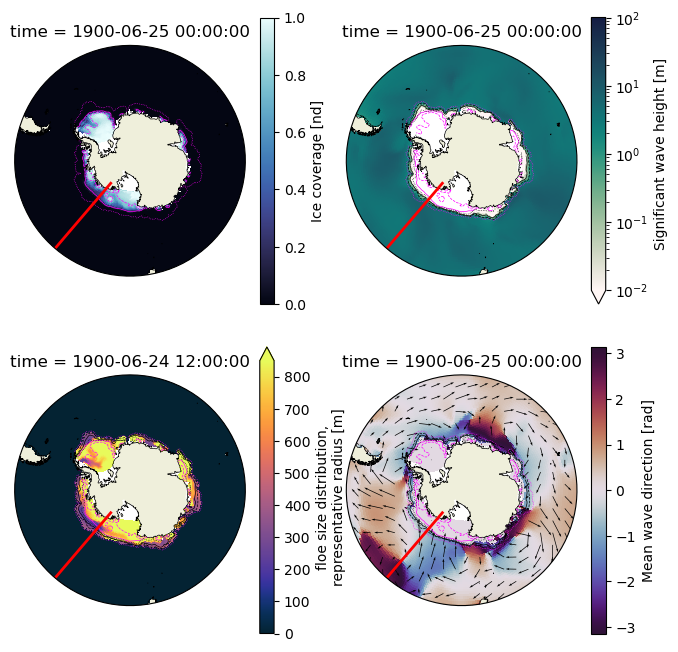

In [64]:
hemisphere = "south"
time_idx = -1
nx_idx = 140

# Slice time
ds_plot = ds_ww3.isel(time=time_idx)
time = ds_plot.time
# ds_plot_cice = ds_cice.sel(time=time, method="nearest")
ds_plot_cice = ds_cice.isel(time=time_idx)
# Setup polar projection
proj = ccrs.SouthPolarStereo()
dims = [2,2]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

# Plot ICE on the map
settings = get_plot_settings("ICE")

ds_plot["ICE"].plot(ax=axes[0], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot, hemisphere, projection)


# ds_plot["HS"].plot(ax=axes[1], x="lon", y="lat", 
#                       # cmap=settings.get("cmap"),
#                       # vmin=settings.get("vmin"),
#                       # vmax=settings.get("vmax"),
#                     cmap=cmo.tempo,
#                     transform=ccrs.PlateCarree(),
# ) 

ds_plot["HS"].plot(
    ax=axes[1],
    x="lon",
    y="lat",
    cmap=cmo.tempo,
    norm=mcolors.LogNorm(vmin=1e-2, vmax=100),
    transform=ccrs.PlateCarree(),
)

cs = add_ice_contours(axes[1], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[1], ds_plot, hemisphere, projection)

# if (ATTEN_OPT == "IC4M2") or (ATTEN_OPT == "IC4M6"):
settings = get_plot_settings("fsdrad")
ds_plot_cice["fsdrad"].plot(ax=axes[2], x="TLON", y="TLAT", 
                    cmap=settings.get("cmap"),
                    vmin=settings.get("vmin"),
                    vmax=settings.get("vmax"),
                    transform=ccrs.PlateCarree(),
) 
# else:
#     ds_plot["ICEF"].plot(ax=axes[2], x="lon", y="lat", 
#                           # cmap=settings.get("cmap"),
#                           # vmin=settings.get("vmin"),
#                           # vmax=settings.get("vmax"),
#                         cmap=cmo.tempo,
#                         transform=ccrs.PlateCarree(),
#     ) 

cs = add_ice_contours(axes[2], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[2], ds_plot, hemisphere, projection)

# zero degrees representing waves coming from the north
theta_rad = ds_plot["THM"].values #- np.pi #𝜋 # We subtract pi so that 
arrow_mag = ds_plot["HS"].values
U = arrow_mag * np.cos(theta_rad)  # x-component
V = arrow_mag * np.sin(theta_rad)  # y-component

# Subsample the data for plotting arrows (too many arrows can clutter the plot)
stride = 5  # plot every 5th point
lon_quiver = ds_plot['lon'].values[::stride, ::stride]
lat_quiver = ds_plot['lat'].values[::stride, ::stride]
U_quiver = U[::stride, ::stride]
V_quiver = V[::stride, ::stride]

# Plot background mean direction
ds_plot["THM"].plot(ax=axes[3], x="lon", y="lat", 
                    cmap='twilight_shifted',
                    transform=ccrs.PlateCarree()
)

# Overlay quivers
axes[3].quiver(lon_quiver, lat_quiver, U_quiver, V_quiver,
               transform=ccrs.PlateCarree(),
               scale=100, regrid_shape=20, color='k')

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)

# # Add coastlines and grid
# ax.coastlines()
# ax.gridlines(draw_labels=False, linestyle="--", alpha=0.5)

# --- Add red line at nx_idx ---
# If nx is an index along longitude:
lats = ds_plot["lat"].isel(nx=nx_idx)
lons = ds_plot["lon"].isel(nx=nx_idx)

for ax in axes:
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )
    # ax.legend()

# plt.legend()
# plt.show()

In [65]:
# dims = [1,3]
# fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

# p1 = axes[0].pcolormesh(tlon, tlat, ds_cice['aice'].isel(time=time_idx), transform=transform, cmap=cmo.ice)
# # axes[0].set_title('CICE mean thickness ($h_i$)')
# plt.colorbar(p1, ax=axes[0], orientation='horizontal', pad=0.05)

# p1 = axes[1].pcolormesh(tlon, tlat, ds_cice['fsdrad'].isel(time=time_idx), transform=transform, cmap=cmo.thermal)
# # axes[1].set_title('CICE mean thickness ($h_i$)')
# plt.colorbar(p1, ax=axes[1], orientation='horizontal', pad=0.05)

# p1 = axes[2].pcolormesh(tlon, tlat, ds_ww3['HS'].isel(time=time_idx), transform=transform, cmap='viridis')
# # axes[2].set_title('CICE mean thickness ($h_i$)')
# plt.colorbar(p1, ax=axes[2], orientation='horizontal', pad=0.05)


# region_extent = [-180, 180, -80, -65] 

# for ax in axes:
#     # Limit to your region in PlateCarree
#     ax.set_extent(region_extent, crs=ccrs.PlateCarree())


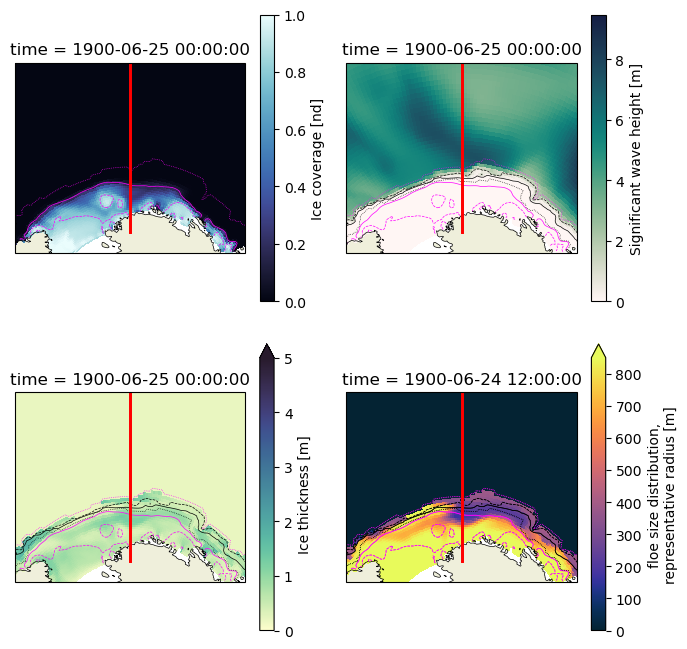

In [66]:
# region_extent = [30, 60, -72, -55]
# nx_idx = best_nx

region_extent = [ds_ww3['lon'].isel(nx=nx_idx)[0].values-30, 
                 ds_ww3['lon'].isel(nx=nx_idx)[0].values+30, 
                 -80, 
                 -50]

# PLOT FOR A REGION
hemisphere = "regional"
shape = "rectangular"
# Slice time
ds_plot = ds_ww3.isel(time=time_idx)

# Setup polar projection
proj = proj = ccrs.Stereographic(central_latitude=(region_extent[2] + region_extent[3])/2, 
                                 central_longitude=(region_extent[0] + region_extent[1])/2)
dims = [2,2]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere, projection=proj, shape=shape)

# Plot ICE on the map
settings = get_plot_settings("ICE")

ds_plot["ICE"].plot(ax=axes[0], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot, hemisphere, projection)


ds_plot["HS"].plot(ax=axes[1], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.tempo,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[1], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[1], ds_plot, hemisphere, projection)


settings = get_plot_settings("hi")
# ds_plot_cice["hi"].plot(ax=axes[2], x="TLON", y="TLAT", 
#                     cmap=settings.get("cmap"),
#                     vmin=settings.get("vmin"),
#                     vmax=settings.get("vmax"),
#                     transform=ccrs.PlateCarree(),
# ) 
ds_plot["ICEH"].plot(ax=axes[2], x="lon", y="lat", 
                    cmap=settings.get("cmap"),
                    vmin=settings.get("vmin"),
                    vmax=settings.get("vmax"),
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[2], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[2], ds_plot, hemisphere, projection)



settings = get_plot_settings("fsdrad")

ds_plot_cice["fsdrad"].plot(ax=axes[3], x="TLON", y="TLAT", 
                    cmap=settings.get("cmap"),
                    vmin=settings.get("vmin"),
                    vmax=settings.get("vmax"),
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)

# # zero degrees representing waves coming from the north
# theta_rad = ds_plot["THM"].values # - np.pi #𝜋 # We subtract pi so that 
# arrow_mag = ds_plot["HS"].values
# U = arrow_mag * np.cos(theta_rad)  # x-component (longitude)
# V = arrow_mag * np.sin(theta_rad)  # y-component (latitude)

# # Subsample the data for plotting arrows (too many arrows can clutter the plot)
# stride = 2  # plot every 5th point
# lon_quiver = ds_plot['lon'].values[::stride, ::stride]
# lat_quiver = ds_plot['lat'].values[::stride, ::stride]
# U_quiver = U[::stride, ::stride]
# V_quiver = V[::stride, ::stride]

# Plot background mean direction
# ds_plot["THM"].plot(ax=axes[3], x="lon", y="lat", 
#                     cmap='twilight_shifted',
#                     transform=ccrs.PlateCarree()
# )

# # Overlay quivers
# axes[3].quiver(lon_quiver, lat_quiver, U_quiver, V_quiver,
#                transform=ccrs.PlateCarree(),
#                scale=100, regrid_shape=20, color='k')

# # Compute propagation direction
# theta_rad = ds_plot["THM"].values
# theta_prop = theta_rad + np.pi
# arrow_mag = ds_plot["HS"].values
# U = arrow_mag * np.cos(theta_prop)
# V = arrow_mag * np.sin(theta_prop)

# # Meshgrid for lon/lat
# lon2d, lat2d = np.meshgrid(ds_plot['lon'].values, ds_plot['lat'].values)
# stride = 2
# lon_quiver = lon2d[::stride, ::stride]
# lat_quiver = lat2d[::stride, ::stride]
# U_quiver = U[::stride, ::stride]
# V_quiver = V[::stride, ::stride]

# # Plot quivers
# axes[3].quiver(lon_quiver, lat_quiver, U_quiver, V_quiver,
#                transform=ccrs.PlateCarree(),
#                scale=1, width=0.003, color='k', zorder=10)

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)

# # Add coastlines and grid
# ax.coastlines()
# ax.gridlines(draw_labels=False, linestyle="--", alpha=0.5)

# --- Add red line at nx_idx ---
# If nx is an index along longitude:
lats = ds_plot["lat"].isel(nx=nx_idx)
lons = ds_plot["lon"].isel(nx=nx_idx)

for ax in axes:
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )
    # ax.legend()

# plt.legend()
# plt.show()
# Define your region bounds (lon_min, lon_max, lat_min, lat_max)


for ax in axes:
    # Limit to your region in PlateCarree
    ax.set_extent(region_extent, crs=ccrs.PlateCarree())
    
    # Add red line at nx_idx
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )

# t = ds_plot['time']
# t_str = np.datetime_as_string(t, unit='D').replace('-', '')
plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/regional_basic_plot_test.png", dpi=600)
plt.show()

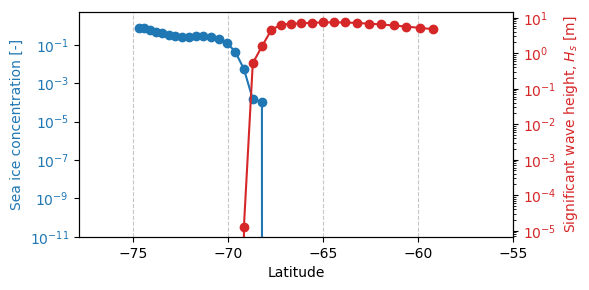

In [67]:
ny_slice=slice(0,45)

fig, ax1 = plt.subplots(1,1, figsize=(6,3))

# Extract transect
ds_transect = ds_ww3.isel(time=time_idx, nx=nx_idx, ny=ny_slice)

# Use latitude for x-axis
x_vals = ds_transect["lat"].values

# First variable: ICE
ax1.plot(x_vals, ds_transect["ICE"].values, color="tab:blue", label="ICE", marker='o')
ax1.set_ylabel("Sea ice concentration [-]", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(PUNY, 5)
ax1.set_yscale('log')

# Second variable: HS (on twin axis)
ax2 = ax1.twinx()
ax2.plot(x_vals, ds_transect["HS"].values, color="tab:red", label="HS", marker='o')
ax2.set_ylabel("Significant wave height, $H_s$ [m]", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_yscale('log')

# Grid lines
ax1.grid(True, which="both", axis="x", linestyle="--", alpha=0.7)

# Mark ice edges
# ax1.axvline(ds_transect["lat"].values[ice_edge_idx], color='gray', linestyle='-')
# ax1.axvline(ds_transect["lat"].values[p01_ice_edge_idx], color='gray', linestyle='--')
# ax1.axvline(ds_transect["lat"].values[puny_ice_edge_idx], color='gray', linestyle=':')

ax1.set_xlim([x_vals.min(), -55])
ax1.set_xlabel('Latitude')
plt.tight_layout()
plt.show()

In [57]:
# print(tlon.min().values, tlon.max().values)